# Setup

Service account

In [27]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/witj/.google/service_accounts/julia-vertexai.json"

Import Packages


In [3]:
import kfp.dsl as dsl
from kfp.v2 import compiler
import kfp.components as kfp_comp
from kfp.v2.dsl import Dataset, Output, Input, component

GCP Config


In [4]:
GCP_PROJECT="dss2022-julia-and-vertexai"
GCS_BUCKET="gs://dss2022-julia-and-vertexai"
GCP_LOCATION="us-central1"

In [5]:
os.environ["PROJECT_ID"]=GCP_PROJECT

# Build Vertex AI pipeline

Component to ingest experimenet data

In [28]:
@component(
    packages_to_install=["google-cloud"],
    base_image="python:3.9"
)
def ingest_experiment_data(
    gcs_experiment_bucket: str,
    gcs_experiment_path: str,
    loads: Output[Dataset],
    units: Output[Dataset],
    units_maintenance: Output[Dataset],
    exchanges: Output[Dataset],
    weights: Output[Dataset]
):
    from google.cloud import storage
    storage_client = storage.Client()
    bucket = storage_client.bucket(gcs_experiment_bucket)

    for (fn, of) in zip(
        ["Loads.csv", "Units.csv", "UnitMaintenances.csv", "Exchanges.csv", "Weights.csv"],
        [loads, units, units_maintenance, exchanges, weights]):
        blob = bucket.blob(f"{gcs_experiment_path}/{fn}")
        print(f"Src file={blob.bucket} / {blob.name}")   
        print(f"Output file={of.path}")
        blob.download_to_filename(of.path)

Component to augment energy load data

In [29]:
@component(
    packages_to_install=["pandas"],
    base_image="python:3.9"
)
def augment_loads(
    demand_aug_ratio: float,
    loads: Input[Dataset],
    augmented_loads: Output[Dataset]
):
    import pandas as pd
    loads_df = pd.read_csv(loads.path)
    loads_df["Baseline"] = loads_df["Baseline"]*demand_aug_ratio
    loads_df.to_csv(augmented_loads.path)

Vertex AI Pipeline component to run Julia code

In [8]:
julia_comp = kfp_comp.load_component_from_file(filename="julia_component.yaml")

In [9]:
julia_comp


<function Julia component(demand_aug_ratio: float, loads: 'Dataset', units: 'Dataset', units_maintenance: 'Dataset', exchanges: 'Dataset', weights: 'Dataset')>

Vertex AI Pipeline

In [30]:
@dsl.pipeline(
    name="juliacomponent",
    pipeline_root=GCS_BUCKET
)
def pipeline(demand_aug_ratio: float=1.0, experiment_bucket: str="", experiment_path: str=""):
    ingest_experiment_data_op = ingest_experiment_data(experiment_bucket, experiment_path)
    augment_loads_op = augment_loads(demand_aug_ratio=demand_aug_ratio, loads=ingest_experiment_data_op.outputs["loads"])
    julia_op = julia_comp(demand_aug_ratio,  
        augment_loads_op.outputs["augmented_loads"],
        ingest_experiment_data_op.outputs["units"],
        ingest_experiment_data_op.outputs["units_maintenance"],
        ingest_experiment_data_op.outputs["exchanges"],
        ingest_experiment_data_op.outputs["weights"],
    )


Compile pipeline into json format

In [31]:
compiler.Compiler().compile(pipeline_func=pipeline,
                            package_path="julia_comp.json")

/Users/witj/projects/conf-dss2022-julia-and-vertexai/notebooks/venv/lib/python3.10/site-packages/kfp/v2/compiler/compiler.py:1290: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  warnings.warn(


# Run pipeline

In [32]:
from google.cloud import aiplatform
import datetime

Name Vertex AI experiment for the run

In [33]:
EXPERIMENT = f'uc-demand-sensitivity-{datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'


In [34]:
EXPERIMENT


'uc-demand-sensitivity-2022-12-16-15-56-04'

In [35]:
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    "/Users/witj/.google/service_accounts/julia-vertexai.json")

Init Vertex AI experiment 

In [36]:
aiplatform.init(
        experiment=EXPERIMENT,
        experiment_description="Demand changes to energy production costs",
        project=GCP_PROJECT,        
        location="us-central1",
        # credentials=credentials,
        staging_bucket=f"{GCS_BUCKET}/runs-meta",
        # encryption_spec_key_name=f"projects/{GCP_PROJECT}/locations/us-central1/keyRings/julia-vertexai-keyring/cryptoKeys/julia-vertexai-key"
        # service_account="/Users/witj/.google/service_accounts/julia-vertexai.json"
    )    

Schedule pipelines runs

In [37]:
import numpy as np

for ratio in np.linspace(0.9, 1.1, num=10):
    job = aiplatform.PipelineJob(
        display_name="julia-vertexai",
        template_path="julia_comp.json",
        pipeline_root=f"{GCS_BUCKET}/runs-meta",
        parameter_values={
            "experiment_bucket":"dss2022-julia-and-vertexai",
            "experiment_path":"data",
            "demand_aug_ratio": ratio
        },
        enable_caching=False,
        project=GCP_PROJECT)

    job.submit(experiment=EXPERIMENT,
        service_account="julia-vertexai@dss2022-julia-and-vertexai.iam.gserviceaccount.com")
    job.run(service_account="julia-vertexai@dss2022-julia-and-vertexai.iam.gserviceaccount.com", 
        sync=False)

Creating PipelineJob
PipelineJob created. Resource name: projects/820862384401/locations/us-central1/pipelineJobs/juliacomponent-20221216155712
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/820862384401/locations/us-central1/pipelineJobs/juliacomponent-20221216155712')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/juliacomponent-20221216155712?project=820862384401
Associating projects/820862384401/locations/us-central1/pipelineJobs/juliacomponent-20221216155712 to Experiment: uc-demand-sensitivity-2022-12-16-15-56-04
Creating PipelineJob
Creating PipelineJob
PipelineJob created. Resource name: projects/820862384401/locations/us-central1/pipelineJobs/juliacomponent-20221216155720
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/820862384401/locations/us-central1/pipelineJobs/juliacomponent-20221216155720')
View Pipeline Job:
https://consol

Creating PipelineJob


# Analyze runs

In [38]:
import pandas as pd

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,3)

Download information about runs from the experiment

In [40]:
experiments_df = aiplatform.get_experiment_df("uc-demand-sensitivity-2022-12-10-11-46-51")

In [41]:
experiments_df

,experiment_name,run_name,run_type,state,param.experiment_path,param.demand_aug_ratio,param.experiment_bucket,metric.variable_cost,metric.startup_cost,metric.co2_cost,metric.fixed_cost,metric.objective_cost
0,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114735,system.PipelineRun,COMPLETE,data,1.100000,dss2022-julia-and-vertexai,1.093978e+07,20550.000000,3.121852e+06,164746.000000,3.132977e+09
1,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114731,system.PipelineRun,COMPLETE,data,1.077778,dss2022-julia-and-vertexai,1.087551e+07,6100.000000,2.979383e+06,154642.000000,2.990419e+09
2,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114728,system.PipelineRun,COMPLETE,data,1.055556,dss2022-julia-and-vertexai,1.072707e+07,1700.000000,2.840805e+06,150763.000000,2.851685e+09
3,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114724,system.PipelineRun,COMPLETE,data,1.033333,dss2022-julia-and-vertexai,1.053396e+07,1400.000000,2.708494e+06,149449.000000,2.719179e+09
4,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114720,system.PipelineRun,COMPLETE,data,1.011111,dss2022-julia-and-vertexai,1.033133e+07,2000.000000,2.583618e+06,147834.000000,2.594099e+09
5,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114716,system.PipelineRun,COMPLETE,data,0.988889,dss2022-julia-and-vertexai,1.011964e+07,4404.000000,2.467317e+06,145684.000000,2.477587e+09
6,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114711,system.PipelineRun,COMPLETE,data,0.966667,dss2022-julia-and-vertexai,9.919277e+06,3858.000001,2.356494e+06,143311.000001,2.366560e+09
7,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114707,system.PipelineRun,COMPLETE,data,0.944444,dss2022-julia-and-vertexai,9.705563e+06,4708.000000,2.253470e+06,141437.000000,2.263321e+09
8,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114703,system.PipelineRun,COMPLETE,data,0.922222,dss2022-julia-and-vertexai,9.482756e+06,5468.000000,2.159496e+06,138781.000000,2.169123e+09
9,uc-demand-sensitivity-2022-12-10-11-46-51,juliacomponent-20221210114659,system.PipelineRun,COMPLETE,data,0.900000,dss2022-julia-and-vertexai,9.249047e+06,6522.000000,2.075554e+06,135535.000000,2.084945e+09


In [42]:
experiments_df.sort_values(by="param.demand_aug_ratio", inplace=True)

<AxesSubplot: xlabel='param.demand_aug_ratio'>

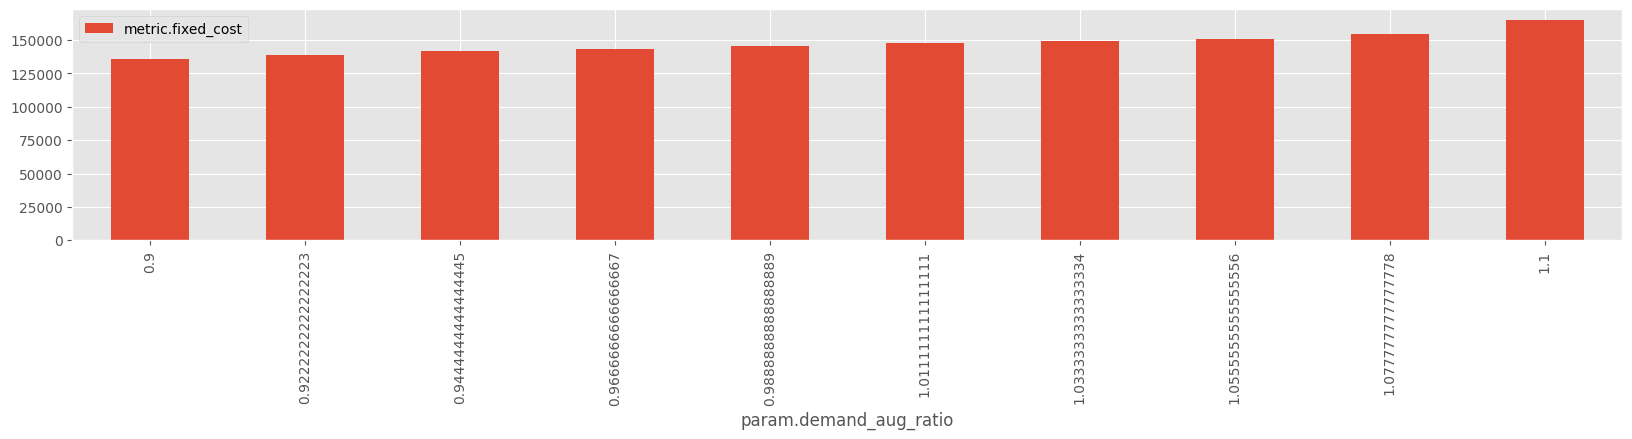

In [43]:
experiments_df.plot.bar(x="param.demand_aug_ratio", y="metric.fixed_cost")

<AxesSubplot: xlabel='param.demand_aug_ratio'>

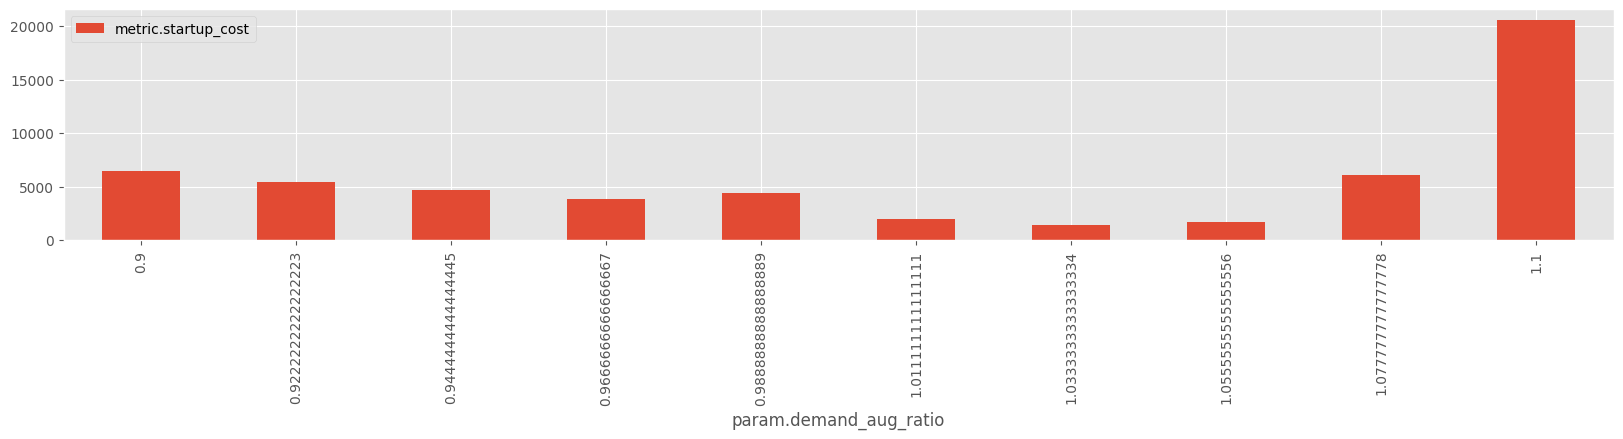

In [44]:
experiments_df.plot.bar(x="param.demand_aug_ratio", y="metric.startup_cost")

<AxesSubplot: xlabel='param.demand_aug_ratio'>

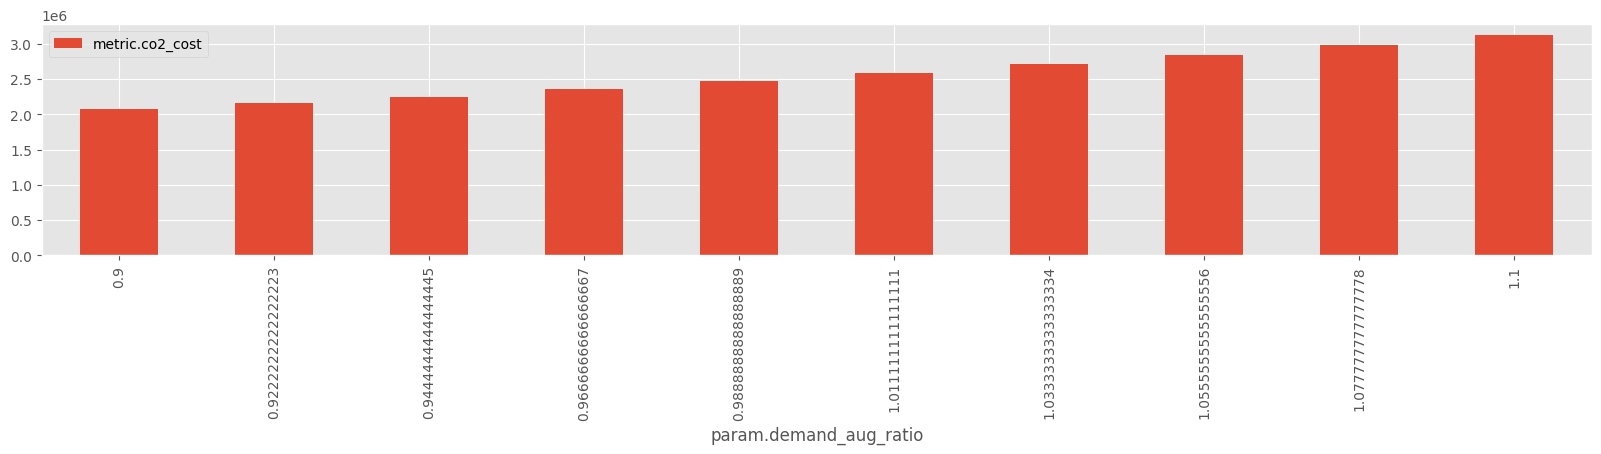

In [26]:
experiments_df.plot.bar(x="param.demand_aug_ratio", y="metric.co2_cost")

<AxesSubplot: xlabel='param.demand_aug_ratio'>

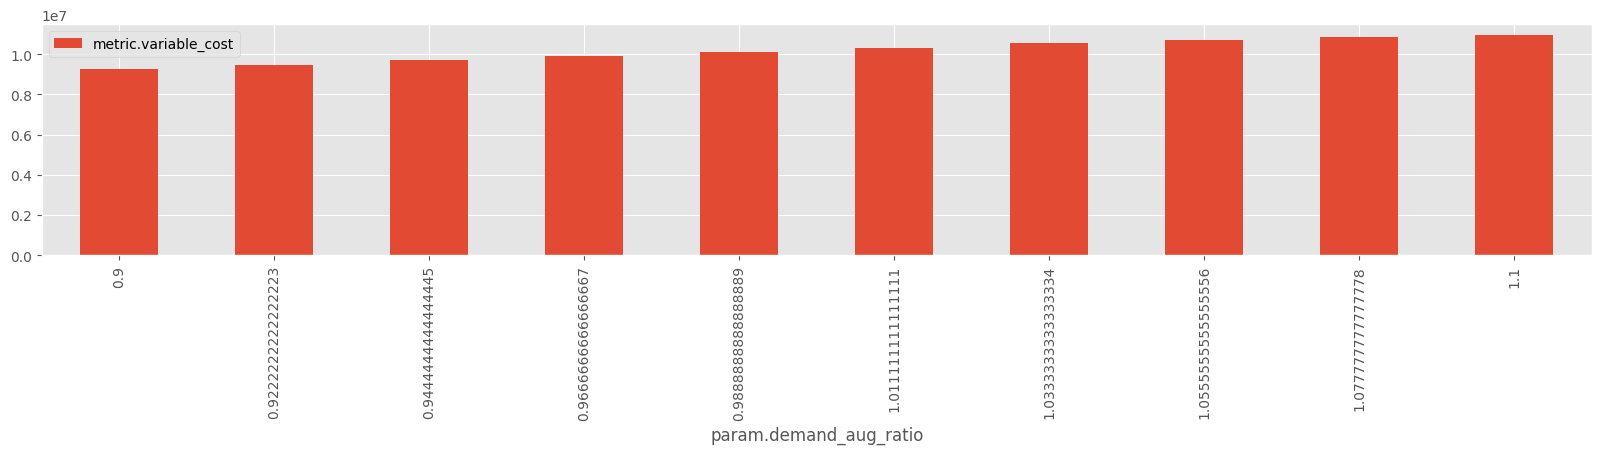

In [24]:
experiments_df.plot.bar(x="param.demand_aug_ratio", y="metric.variable_cost")